In [1]:
import pandas as pd
import os, sys
sys.path.append(os.getcwd()[:-9])  # add repo root to path
from utils import get_repo_root, bucketize_sum_month_lags
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
repo_root = get_repo_root()

In [3]:
cust_hist = pd.read_csv(str(repo_root) + '/data/customer_history.csv')
cust = pd.read_csv(str(repo_root) + '/data/customers.csv')
ref_test = pd.read_csv(str(repo_root) + '/data/referance_data_test.csv')
ref = pd.read_csv(str(repo_root) + '/data/referance_data.csv')
sample_sub = pd.read_csv(str(repo_root) + '/data/sample_submission.csv')

Customer Dataset Feature Engineering

In [4]:
ref

,cust_id,ref_date,churn
0,0,2017-09-01,0
1,3,2018-10-01,0
2,5,2018-03-01,1
3,6,2018-04-01,1
4,7,2018-05-01,0
...,...,...,...
133282,199995,2018-09-01,0
133283,199996,2018-06-01,0
133284,199997,2018-12-01,0
133285,199998,2018-02-01,1


In [5]:
cust_encoded = pd.get_dummies(cust, columns=['gender', 'work_type', 'work_sector', 'religion', 'province'], drop_first=True, dtype=int)

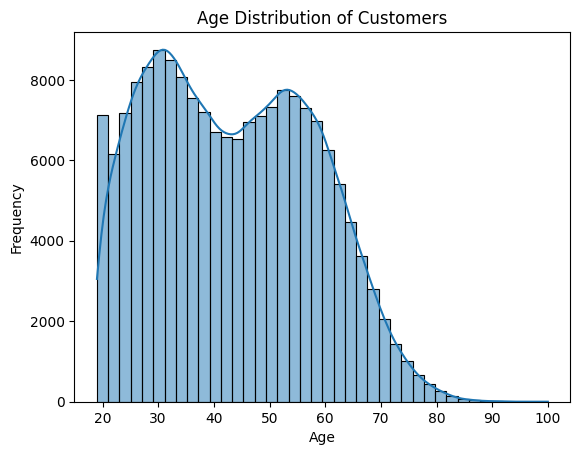

In [6]:
sns.histplot(cust_encoded['age'], bins=40, kde=True)
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [7]:
cust_encoded['age_bin'] = pd.qcut(cust_encoded['age'], q = 10, labels = False)

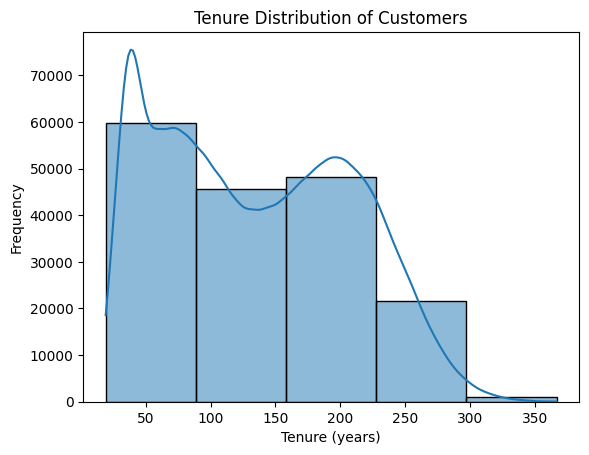

In [8]:
sns.histplot(cust_encoded['tenure'], bins = 5, kde = True)
plt.title('Tenure Distribution of Customers')
plt.xlabel('Tenure (years)')
plt.ylabel('Frequency')
plt.show()

In [9]:
cust_encoded['tenure_bin'] = pd.qcut(cust_encoded['tenure'], q = 5, labels = False)

In [10]:
cust_encoded.head()

,cust_id,age,tenure,gender_M,work_type_Part-time,work_type_Retired,work_type_Self-employed,work_type_Student,work_type_Unemployed,work_sector_Finance,...,province_GRO,province_LIM,province_NOB,province_NOH,province_OVE,province_UTR,province_ZEE,province_ZUI,age_bin,tenure_bin
0,0,64,135,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,9,2
1,1,57,65,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,7,1
2,2,62,224,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,8,4
3,3,22,47,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,27,108,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,2


Customer History Dataset Feature Engineering

In [11]:
ref_all = pd.concat([ref, ref_test], ignore_index=True)
ref_all

,cust_id,ref_date,churn
0,0,2017-09-01,0.0
1,3,2018-10-01,0.0
2,5,2018-03-01,1.0
3,6,2018-04-01,1.0
4,7,2018-05-01,0.0
...,...,...,...
176288,199951,2019-03-01,NaN
176289,199952,2019-05-01,NaN
176290,199963,2019-05-01,NaN
176291,199964,2019-03-01,NaN


In [12]:
cust_hist_ref_dates = cust_hist.merge(ref_all[['cust_id', 'ref_date']], on='cust_id', how='left')

In [13]:
cust_hist_ref_dates.head(5)

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date
0,0,2016-01-01,1.0,2,151.20,NaN,NaN,2017-09-01
1,0,2016-02-01,1.0,2,178.70,NaN,NaN,2017-09-01
2,0,2016-03-01,2.0,2,37.38,NaN,NaN,2017-09-01
3,0,2016-04-01,4.0,2,100.90,NaN,NaN,2017-09-01
4,0,2016-05-01,3.0,3,132.28,NaN,NaN,2017-09-01


In [14]:
def _safe_div(a, b):
    return np.where(b == 0, np.nan, a / b)

In [15]:
'''
Feature Engineering on Transaction Data
'''
cust_hist_ref_dates['avg_ticket_eft'] = _safe_div(cust_hist_ref_dates['mobile_eft_all_amt'], cust_hist_ref_dates['mobile_eft_all_cnt'])
cust_hist_ref_dates['avg_cc'] = _safe_div(cust_hist_ref_dates['cc_transaction_all_amt'], cust_hist_ref_dates['cc_transaction_all_cnt'])
# channel mix & intensity
cust_hist_ref_dates['total_cnt'] = cust_hist_ref_dates['mobile_eft_all_cnt'] + cust_hist_ref_dates['cc_transaction_all_cnt']
cust_hist_ref_dates['total_amt'] = cust_hist_ref_dates['mobile_eft_all_amt'] + cust_hist_ref_dates['cc_transaction_all_amt']
cust_hist_ref_dates['share_eft_cnt'] = _safe_div(cust_hist_ref_dates['mobile_eft_all_cnt'], cust_hist_ref_dates['total_cnt'])
cust_hist_ref_dates['share_cc_cnt'] = _safe_div(cust_hist_ref_dates['cc_transaction_all_cnt'], cust_hist_ref_dates['total_cnt'])
cust_hist_ref_dates['share_eft_amt'] = _safe_div(cust_hist_ref_dates['mobile_eft_all_amt'], cust_hist_ref_dates['total_amt'])
cust_hist_ref_dates['share_cc_amt'] = _safe_div(cust_hist_ref_dates['cc_transaction_all_amt'], cust_hist_ref_dates['total_amt'])

In [16]:

def _activity_recency(df: pd.DataFrame) -> pd.DataFrame:
    """Vectorized recency & activity features for speed at scale.
        Assumes df index is sorted by date for a single customer.
    """
    df = df.sort_values(['cust_id','date'])
    df['active_flag'] = ((df['mobile_eft_all_cnt'].fillna(0) + df['cc_transaction_all_cnt'].fillna(0)) > 0).astype(np.int8)
    # per-customer time index
    df['t'] = df.groupby('cust_id').cumcount().astype(np.int32)
    df['cust_age_months'] = df['t'] + 1 # months of history so far (1-based)
    # last active index per row
    df['last_active_idx'] = np.where(df['active_flag'].values == 1, df['t'].values, -1)
    df['last_active_ff'] = df.groupby('cust_id')['last_active_idx'].cummax()
    # months since last active (NaN if never active yet)
    msa = df['t'] - df['last_active_ff']
    df['months_since_active'] = msa.where(df['last_active_ff']!=-1, df['t'] - df['last_active_ff']).astype(float)
    # inactivity current run length
    df['inactive_run_len'] = np.where(df['active_flag'].values==0, df['t'] - df['last_active_ff'], 0).astype(np.int16)
    # windowed active months via cumsum per customer
    csum = df.groupby('cust_id')['active_flag'].cumsum()
    for w in (3, 6, 12, 24):
        # partial-window count (fast, always defined)
        df[f'active_months_{w}m'] = (csum - csum.groupby(df['cust_id']).shift(w).fillna(0)).astype(np.int16)
        # coverage = min(w, cust_age_months)
        df[f'coverage_{w}m'] = np.minimum(w, df['cust_age_months']).astype(np.int16)
        # ratio normalized by available history length (0..1)
        df[f'active_ratio_{w}m'] = (df[f'active_months_{w}m'] / df[f'coverage_{w}m'].replace(0, np.nan)).astype(float)
        # strict-window variant: NaN if insufficient history (< w)
        df[f'active_months_{w}m_strict'] = np.where(df['cust_age_months'] < w, np.nan, df[f'active_months_{w}m']).astype('float32')
    out_cols = [
'cust_id','date','active_flag','months_since_active','inactive_run_len','cust_age_months',
'active_months_3m','active_months_6m','active_months_12m','active_months_24m',
'coverage_3m','coverage_6m','coverage_12m','coverage_24m',
'active_ratio_3m','active_ratio_6m','active_ratio_12m','active_ratio_24m',
'active_months_3m_strict','active_months_6m_strict','active_months_12m_strict','active_months_24m_strict'
]
    out = df[out_cols]
    return out


In [17]:
df = _activity_recency(cust_hist_ref_dates)

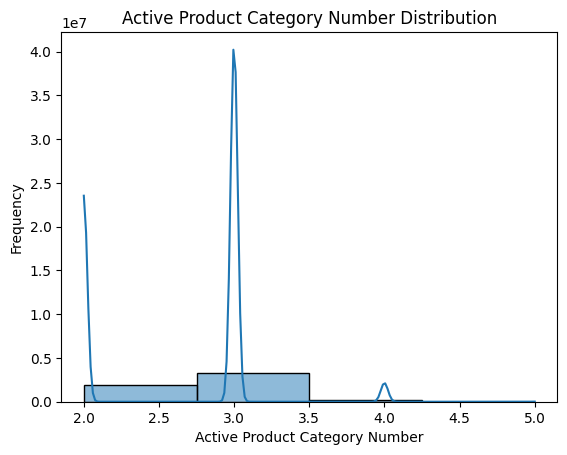

In [18]:
sns.histplot(cust_hist_ref_dates['active_product_category_nbr'], bins = 4, kde=True)
plt.title('Active Product Category Number Distribution')
plt.xlabel('Active Product Category Number')
plt.ylabel('Frequency')
plt.show()

In [15]:
# ------------------ Core blocks on HISTORY (pre-ref) ------------------
def base_rolling_features(hist, windows):
    """Basic rolling stats, coverage, last/nonzero & recency."""
    hist = hist.sort_values(["cust_id", "date"]).copy()
    g = hist.groupby("cust_id", group_keys=False)

    num_cols = [c for c in hist.columns
                if c not in ["cust_id", "date"] and pd.api.types.is_numeric_dtype(hist[c])]

    #num_cols = ['mobile_eft_all_amt', 'cc_transaction_all_amt']
    for col in num_cols:
        # last value, nonzero flag
        hist[f"{col}_last"] = hist[col]
        hist[f"{col}_last_month_nonzero"] = (hist[col] > 0).astype(int)

        for w in windows:
            r = g[col].rolling(w, min_periods=1)
            hist[f"{col}_sum_w{w}"]  = r.sum().reset_index(level=0, drop=True)
            hist[f"{col}_mean_w{w}"] = r.mean().reset_index(level=0, drop=True)
            hist[f"{col}_max_w{w}"]  = r.max().reset_index(level=0, drop=True)

            # std & coverage
            mp = 2 if w >= 2 else 1
            stdv = g[col].rolling(w, min_periods=mp).std(ddof=0).reset_index(level=0, drop=True)
            hist[f"{col}_std_w{w}"] = stdv.fillna(0)

            cnt = g[col].rolling(w, min_periods=1).count().reset_index(level=0, drop=True)
            hist[f"months_covered_w{w}"] = cnt
            hist[f"coverage_ratio_w{w}"] = cnt / float(w)

    # Recency (days) — customer-dependent (no synthetic fills)
    date_i = hist["date"].astype("int64")
    for col in num_cols:
        any_dates = date_i.where(hist[col].notna())
        last_any  = any_dates.groupby(hist["cust_id"]).ffill()
        hist[f"{col}_recency_any_days"] = (date_i - last_any) / (1e9*60*60*24)

        pos_dates = date_i.where(hist[col].fillna(0) > 0)
        last_pos  = pos_dates.groupby(hist["cust_id"]).ffill()
        hist[f"{col}_recency_pos_days"] = (date_i - last_pos) / (1e9*60*60*24)

    return hist, num_cols

In [20]:
# Base & advanced windows (row-based)
BASE_WINDOWS = (1, 3, 6, 12)
EWMA_SPANS   = (3, 6, 12)              # exponential moving averages
MOM_WINDOWS  = (1, 3, 6)               # momentum deltas vs mean/ewma
VOL_WINDOWS  = (3, 6, 12)              # rolling std, cv, drawdown

# Limit automatic pairwise ratios to avoid blow-up
MAX_RATIO_COLS = 6                     # top-K numeric columns by variance

In [20]:
cust_hist_ref_dates.dtypes

cust_id                          int64
date                            object
mobile_eft_all_cnt             float64
active_product_category_nbr      int64
mobile_eft_all_amt             float64
cc_transaction_all_amt         float64
cc_transaction_all_cnt         float64
ref_date                        object
dtype: object

In [16]:
def month_start(series):
    return pd.to_datetime(pd.to_datetime(series).dt.strftime("%Y-%m-01"))

In [17]:
cust_hist_ref_dates['date'] = month_start(cust_hist_ref_dates['date'])

In [18]:
cust_hist_ref_dates

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date
0,0,2016-01-01,1.0,2,151.20,NaN,NaN,2017-09-01
1,0,2016-02-01,1.0,2,178.70,NaN,NaN,2017-09-01
2,0,2016-03-01,2.0,2,37.38,NaN,NaN,2017-09-01
3,0,2016-04-01,4.0,2,100.90,NaN,NaN,2017-09-01
4,0,2016-05-01,3.0,3,132.28,NaN,NaN,2017-09-01
...,...,...,...,...,...,...,...,...
5359604,199999,2018-02-01,0.0,2,0.00,9.66,1.0,2018-06-01
5359605,199999,2018-03-01,0.0,2,0.00,22.89,2.0,2018-06-01
5359606,199999,2018-04-01,0.0,2,0.00,48.96,3.0,2018-06-01
5359607,199999,2018-05-01,0.0,2,0.00,38.20,2.0,2018-06-01


In [21]:
hist, num_cols = base_rolling_features(cust_hist_ref_dates, BASE_WINDOWS)

/var/folders/2b/mx4641_17dg2lvp9l5wcqsr80000gr/T/ipykernel_21124/3642126601.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hist[f"{col}_max_w{w}"]  = r.max().reset_index(level=0, drop=True)
/var/folders/2b/mx4641_17dg2lvp9l5wcqsr80000gr/T/ipykernel_21124/3642126601.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hist[f"{col}_std_w{w}"] = stdv.fillna(0)
/var/folders/2b/mx4641_17dg2lvp9l5wcqsr80000gr/T/ipykernel_21124/3642126601.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [22]:
num_cols

['mobile_eft_all_cnt',
 'active_product_category_nbr',
 'mobile_eft_all_amt',
 'cc_transaction_all_amt',
 'cc_transaction_all_cnt']

In [23]:
def streak_features(hist, num_cols):
    """
    Zero and active streak lengths (current run lengths per month).
    Robust to pandas index alignment: builds a per-customer DataFrame
    and joins back by the original row index.
    """
    hist = hist.sort_values(["cust_id", "date"]).copy()
    parts = []

    for cid, dfc in hist.groupby("cust_id", sort=False):
        out_cols = {}

        for col in num_cols:
            # ACTIVE streak (value > 0)
            act = (dfc[col].fillna(0) > 0).astype(int)
            act_runs = act.groupby((act != act.shift()).cumsum()).cumcount() + 1
            out_cols[f"{col}_active_streak"] = act_runs.where(act.eq(1), 0)

            # ZERO streak (value == 0)
            zer = (dfc[col].fillna(0) == 0).astype(int)
            zer_runs = zer.groupby((zer != zer.shift()).cumsum()).cumcount() + 1
            out_cols[f"{col}_zero_streak"] = zer_runs.where(zer.eq(1), 0)

        parts.append(pd.DataFrame(out_cols, index=dfc.index))

    streak_df = pd.concat(parts, axis=0).sort_index()
    # index-aligned join back to hist (no index-name issues)
    return hist.join(streak_df)


In [24]:
hist2 = streak_features(hist, num_cols)

In [32]:
hist2.columns

Index(['cust_id', 'date', 'mobile_eft_all_cnt', 'active_product_category_nbr',
       'mobile_eft_all_amt', 'cc_transaction_all_amt',
       'cc_transaction_all_cnt', 'ref_date', 'mobile_eft_all_cnt_last',
       'mobile_eft_all_cnt_last_month_nonzero',
       ...
       'mobile_eft_all_cnt_active_streak', 'mobile_eft_all_cnt_zero_streak',
       'active_product_category_nbr_active_streak',
       'active_product_category_nbr_zero_streak',
       'mobile_eft_all_amt_active_streak', 'mobile_eft_all_amt_zero_streak',
       'cc_transaction_all_amt_active_streak',
       'cc_transaction_all_amt_zero_streak',
       'cc_transaction_all_cnt_active_streak',
       'cc_transaction_all_cnt_zero_streak'],
      dtype='object', length=126)

In [25]:
def ewma_momentum_volatility(hist: pd.DataFrame, num_cols,
                             EWMA_SPANS=(3, 6, 12),
                             MOM_WINDOWS=(3, 6, 12),
                             VOL_WINDOWS=(3, 6, 12)):
    """
    Add per-customer EWMAs, momentum (last - mean/ewma), CV, and rolling drawdowns.
    Vectorized: uses GroupBy.transform and GroupBy.rolling reductions (no .apply on Python funcs).
    """
    df = hist.sort_values(["cust_id", "date"]).copy()
    g = df.groupby("cust_id", group_keys=False)

    for col in num_cols:
        s = df[col]

        # ---------- EWMAs (per customer) ----------
        # transform(lambda ...) is OK here; but no per-row Python work beyond the ewm kernel
        for span in EWMA_SPANS:
            df[f"{col}_ewma_s{span}"] = g[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

        # ---------- Momentum: last minus rolling mean ----------
        for w in MOM_WINDOWS:
            rmean = g[col].rolling(w, min_periods=1).mean().reset_index(level=0, drop=True)
            df[f"{col}_mom_last_minus_mean_w{w}"] = s - rmean

        # Momentum: last minus EWMA (reuses EWMAs above)
        for span in EWMA_SPANS:
            df[f"{col}_mom_last_minus_ewma_s{span}"] = s - df[f"{col}_ewma_s{span}"]

        # ---------- Volatility: coefficient of variation (CV = std / mean) ----------
        # If rolling std/mean were already computed elsewhere (e.g., {col}_std_w{w}, {col}_mean_w{w}),
        # we just combine them; otherwise you can compute them here similarly with groupby().rolling().
        for w in VOL_WINDOWS:
            stdv = df.get(f"{col}_std_w{w}")
            meanv = df.get(f"{col}_mean_w{w}")
            if stdv is not None and meanv is not None:
                denom = meanv.replace(0, np.nan)
                df[f"{col}_cv_w{w}"] = (stdv / denom).fillna(0)

        # ---------- Current drawdown over trailing window w ----------
        # Current drawdown over last w points = (x - rolling_max_w(x)) / rolling_max_w(x)
        for w in (6, 12):
            roll_max = g[col].rolling(w, min_periods=1).max().reset_index(level=0, drop=True)
            denom = roll_max.replace(0, np.nan)
            dd = ((s - roll_max) / denom).fillna(0)
            df[f"{col}_drawdown_w{w}"] = dd

    # (Optional) downcast to save memory
    for c in df.columns:
        if c not in hist.columns:
            if pd.api.types.is_float_dtype(df[c]):
                df[c] = pd.to_numeric(df[c], downcast="float")
            elif pd.api.types.is_integer_dtype(df[c]):
                df[c] = pd.to_numeric(df[c], downcast="integer")

    return df


In [26]:
hist3 = ewma_momentum_volatility(hist2, num_cols)

In [27]:
def diversity_entropy(hist: pd.DataFrame, num_cols):
    """
    Cross-metric diversity (per row): total, shares, Shannon entropy, HHI, breadth.
    Optimized with NumPy (fewer pandas temporaries and Python-level loops).
    """
    df = hist.sort_values(["cust_id", "date"]).copy()

    # Pre-select only the columns we care about once
    num_df = df[num_cols]

    # Keep only nonnegative metrics for shares/entropy/hhi
    # (using column-wise mins avoids scanning each column with Python)
    nonneg_mask = (num_df.min(skipna=True) >= 0)
    pos_cols = list(nonneg_mask.index[nonneg_mask])

    if len(pos_cols) >= 2:
        vals = num_df[pos_cols].clip(lower=0).to_numpy(dtype="float64", copy=True)

        # Totals
        total = vals.sum(axis=1)

        # Shares with safe division
        shares = np.zeros_like(vals, dtype="float64")
        # shares[i, j] = vals[i, j] / total[i] when total[i] > 0
        np.divide(vals, total[:, None], out=shares, where=total[:, None] > 0)

        # Entropy: -sum(p * log p); skip zeros to avoid log(0)
        with np.errstate(divide="ignore", invalid="ignore"):
            plogp = np.where(shares > 0, shares * np.log(shares), 0.0)
        entropy = -plogp.sum(axis=1)

        # HHI: sum(p^2)
        hhi = (shares * shares).sum(axis=1)

        # Breadth: count of metrics > 0
        breadth = (vals > 0).sum(axis=1)

        # Assign back (keep index alignment)
        df["activity_total_last"]   = pd.Series(total,   index=df.index)
        df["activity_entropy_last"] = pd.Series(entropy, index=df.index)
        df["activity_hhi_last"]     = pd.Series(hhi,     index=df.index)
        df["activity_breadth_last"] = pd.Series(breadth, index=df.index).astype("int32")

    else:
        # Fallbacks: still do NumPy once
        vals_all = num_df.clip(lower=0).to_numpy(dtype="float64", copy=True)
        total    = vals_all.sum(axis=1)
        breadth  = (vals_all > 0).sum(axis=1)

        df["activity_total_last"]   = pd.Series(total,  index=df.index)
        df["activity_entropy_last"] = 0.0
        df["activity_hhi_last"]     = 1.0  # fully concentrated
        df["activity_breadth_last"] = pd.Series(breadth, index=df.index).astype("int32")

    # Optional downcast to save memory
    for c in ("activity_total_last", "activity_entropy_last", "activity_hhi_last"):
        if c in df:
            df[c] = pd.to_numeric(df[c], downcast="float")

    return df


In [28]:
hist4 = diversity_entropy(hist3, num_cols)

In [29]:
def customer_normalizations(hist: pd.DataFrame, num_cols):
    """
    Customer-wise z-scores & min-max over trailing 12 rows (robust to scale differences).
    Vectorized across all columns: one rolling block for mean/var/min/max.
    """
    df = hist.sort_values(["cust_id", "date"]).copy()
    g = df.groupby("cust_id", group_keys=False)

    # One rolling block for all numeric columns
    roll = g[num_cols].rolling(window=12, min_periods=3)

    rmean = roll.mean().reset_index(level=0, drop=True)
    rvar  = roll.var(ddof=0).reset_index(level=0, drop=True)  # ddof=0 like your original
    rstd  = np.sqrt(rvar)
    rmin  = roll.min().reset_index(level=0, drop=True)
    rmax  = roll.max().reset_index(level=0, drop=True)

    # Z-score of current value vs trailing window
    z = (df[num_cols] - rmean).div(rstd.replace(0, np.nan))

    # Min–max normalized level of current value vs trailing window
    denom = (rmax - rmin).replace(0, np.nan)
    mm = (df[num_cols] - rmin).div(denom)

    # Attach back with clear names
    z = z.add_suffix("_z_last_w12")
    mm = mm.add_suffix("_minmax_last_w12")

    out = df.join([z, mm])

    # Optional: downcast to save memory/bandwidth
    for c in z.columns.tolist() + mm.columns.tolist():
        out[c] = pd.to_numeric(out[c], downcast="float")

    return out


In [30]:
hist5 = customer_normalizations(hist4, num_cols)

In [31]:
def pairwise_shares_ratios(hist, num_cols, k=MAX_RATIO_COLS):
    """Automatic shares & ratios among the top-K high-variance metrics."""
    hist = hist.sort_values(["cust_id", "date"]).copy()
    # Pick top-K by overall variance
    var_rank = pd.Series({c: np.nanvar(hist[c].values) for c in num_cols}).sort_values(ascending=False)
    top = list(var_rank.index[:k])

    # Row-wise total for these metrics
    total = hist[top].sum(axis=1)
    for c in top:
        hist[f"{c}_share_topk"] = _safe_div(hist[c], total.replace(0, np.nan))

    # Selected pairwise ratios (upper triangle)
    for i in range(len(top)):
        for j in range(i+1, len(top)):
            a, b = top[i], top[j]
            hist[f"{a}_to_{b}_ratio"] = _safe_div(hist[a], hist[b].replace(0, np.nan))

    return hist

def lifetime_and_cohorts(hist):
    """Customer lifetimes, months since first/last seen."""
    hist = hist.sort_values(["cust_id", "date"]).copy()
    first = hist.groupby("cust_id")["date"].transform("min")
    last  = hist.groupby("cust_id")["date"].transform("max")
    hist["months_since_first"] = (hist["date"].dt.to_period("M") - first.dt.to_period("M")).apply(lambda x: x.n)
    hist["months_until_last"]  = (last.dt.to_period("M") - hist["date"].dt.to_period("M")).apply(lambda x: x.n)
    hist["lifetime_months"]    = (last.dt.to_period("M") - first.dt.to_period("M")).apply(lambda x: x.n) + 1
    return hist

def seasonality_encodings(df, date_col="date"):
    """Calendar features at ref granularity (will also be present on hist before merge)."""
    df["month"]   = df[date_col].dt.month
    df["quarter"] = df[date_col].dt.quarter
    # Sine/cosine month-of-year
    df["moy_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["moy_cos"] = np.cos(2*np.pi*df["month"]/12)
    df["is_q_end"] = ((df[date_col].dt.month % 3) == 0).astype(int)
    return df

In [32]:
hist6 = pairwise_shares_ratios(hist5, num_cols)

In [33]:
hist7 = lifetime_and_cohorts(hist6)

In [34]:
def seasonality_encodings(df, date_col="date"):
    """Calendar features at ref granularity (will also be present on hist before merge)."""
    df["month"]   = df[date_col].dt.month
    df["quarter"] = df[date_col].dt.quarter
    # Sine/cosine month-of-year
    df["moy_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["moy_cos"] = np.cos(2*np.pi*df["month"]/12)
    df["is_q_end"] = ((df[date_col].dt.month % 3) == 0).astype(int)
    return df

In [35]:
hist8 = seasonality_encodings(hist7, date_col="date")

In [52]:
features_merged

,cust_id,ref_date,mobile_eft_all_cnt_l0m,mobile_eft_all_cnt_l2m,mobile_eft_all_cnt_l5m,mobile_eft_all_cnt_l8m,mobile_eft_all_cnt_l1year,mobile_eft_all_cnt_l2years,mobile_eft_all_cnt_l4years,active_product_category_nbr_l0m,...,cc_transaction_all_amt_l1year,cc_transaction_all_amt_l2years,cc_transaction_all_amt_l4years,cc_transaction_all_cnt_l0m,cc_transaction_all_cnt_l2m,cc_transaction_all_cnt_l5m,cc_transaction_all_cnt_l8m,cc_transaction_all_cnt_l1year,cc_transaction_all_cnt_l2years,cc_transaction_all_cnt_l4years
0,0,2017-09-01,1.0,4.0,7.0,5.0,13.0,17.0,0.0,2.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-02-01,0.0,1.0,8.0,3.0,4.0,23.0,22.0,3.0,...,826.43,5001.60,1465.50,8.0,22.0,40.0,22.0,21.0,235.0,195.0
2,2,2019-01-01,1.0,5.0,7.0,3.0,5.0,32.0,34.0,3.0,...,51.20,59.13,93.56,7.0,8.0,9.0,9.0,11.0,10.0,19.0
3,3,2018-10-01,2.0,2.0,3.0,6.0,9.0,16.0,19.0,3.0,...,4306.40,7505.34,3216.61,21.0,37.0,62.0,90.0,156.0,321.0,148.0
4,5,2018-03-01,4.0,9.0,10.0,10.0,14.0,17.0,5.0,2.0,...,54.65,978.28,1311.10,3.0,5.0,8.0,8.0,12.0,222.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176288,199995,2018-09-01,5.0,11.0,10.0,3.0,4.0,3.0,10.0,3.0,...,179.09,302.54,4575.49,4.0,141.0,257.0,172.0,81.0,55.0,346.0
176289,199996,2018-06-01,1.0,7.0,9.0,5.0,7.0,25.0,6.0,2.0,...,65.78,146.58,35.21,4.0,5.0,4.0,8.0,8.0,25.0,5.0
176290,199997,2018-12-01,4.0,8.0,15.0,21.0,46.0,187.0,45.0,2.0,...,584.61,5473.04,1850.94,10.0,12.0,14.0,21.0,37.0,240.0,204.0
176291,199998,2018-02-01,6.0,14.0,11.0,15.0,17.0,28.0,2.0,3.0,...,58.94,1120.94,282.27,34.0,94.0,66.0,26.0,10.0,261.0,27.0


In [47]:
num_cols

['mobile_eft_all_cnt',
 'active_product_category_nbr',
 'mobile_eft_all_amt',
 'cc_transaction_all_amt',
 'cc_transaction_all_cnt']

In [36]:
def enrich_active_product_categories(df: pd.DataFrame,
                                     col="active_product_category_nbr"):
    d = df.sort_values(["cust_id", "date"]).copy()
    g = d.groupby("cust_id", group_keys=False)
    s = d[col].astype("float32")

    # ---------- Lags ----------
    for k in (1, 3, 6, 12):
        d[f"{col}_lag{k}"] = g[col].shift(k)

    # ---------- Differences / pct changes ----------
    d[f"{col}_diff1"] = s - g[col].shift(1)
    d[f"{col}_diff3"] = s - g[col].shift(3)
    d[f"{col}_pctchg1"] = (s - g[col].shift(1)) / g[col].shift(1).replace(0, np.nan)
    d[f"{col}_pctchg1"] = d[f"{col}_pctchg1"].replace([np.inf, -np.inf], np.nan).fillna(0).astype("float32")

    # ---------- Up/Down flags & streaks ----------
    chg = d[f"{col}_diff1"].fillna(0)
    up = (chg > 0).astype("int8")
    dn = (chg < 0).astype("int8")
    # streak utility
    def _streak_run(x):
        # run-length per sign state; returns length where state==1 else 0
        boundary = (x != x.shift()) | g["cust_id"].apply(lambda _: False)  # placeholder to keep shape
        # We need customer-wise boundaries: do per-customer cumsum on combined mask
        return x.groupby((x.ne(x.shift()) | d["cust_id"].ne(d["cust_id"].shift())).cumsum()).cumcount() + 1
    # vectorized streaks (no .apply per group):
    up_boundary = d["cust_id"].ne(d["cust_id"].shift()) | up.ne(up.shift())
    up_run_id = up_boundary.cumsum()
    up_len = up.groupby(up_run_id).cumcount().add(1)
    d[f"{col}_up_streak"] = up_len.where(up.eq(1), 0).astype("int16")

    dn_boundary = d["cust_id"].ne(d["cust_id"].shift()) | dn.ne(dn.shift())
    dn_run_id = dn_boundary.cumsum()
    dn_len = dn.groupby(dn_run_id).cumcount().add(1)
    d[f"{col}_down_streak"] = dn_len.where(dn.eq(1), 0).astype("int16")

    # time since last change of count
    changed = (chg != 0).astype("int8")
    chg_boundary = d["cust_id"].ne(d["cust_id"].shift()) | changed.ne(changed.shift())
    chg_run_id = chg_boundary.cumsum()
    chg_len = changed.groupby(chg_run_id).cumcount().add(1)
    d[f"{col}_since_change"] = chg_len.where(changed.eq(0), 0).astype("int16")

    # ---------- Rolling statistics (3/6/12) ----------
    for w in (3, 6, 12):
        r = g[col].rolling(w, min_periods=max(2, w//2))
        mean = r.mean().reset_index(level=0, drop=True)
        std  = r.std(ddof=0).reset_index(level=0, drop=True)
        minn = r.min().reset_index(level=0, drop=True)
        maxx = r.max().reset_index(level=0, drop=True)

        d[f"{col}_mean_w{w}"] = mean.astype("float32")
        d[f"{col}_std_w{w}"]  = std.astype("float32")
        d[f"{col}_cv_w{w}"]   = (std / mean.replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0).astype("float32")
        d[f"{col}_z_last_w{w}"] = ((s - mean) / std.replace(0, np.nan)).astype("float32")
        d[f"{col}_minmax_last_w{w}"] = ((s - minn) / (maxx - minn).replace(0, np.nan)).astype("float32")

        # drawdown from rolling max (are they retreating?)
        roll_max = r.max().reset_index(level=0, drop=True)
        denom = roll_max.replace(0, np.nan)
        d[f"{col}_drawdown_w{w}"] = ((s - roll_max) / denom).fillna(0).astype("float32")

    # ---------- EWMA trend ----------
    for span in (3, 6, 12):
        d[f"{col}_ewma_s{span}"] = g[col].transform(lambda x: x.ewm(span=span, adjust=False).mean()).astype("float32")
        d[f"{col}_mom_last_minus_ewma_s{span}"] = (s - d[f"{col}_ewma_s{span}"]).astype("float32")

    # ---------- OLS slope over trailing 6 (trend direction/strength) ----------
    # slope of y on t=0..k-1 in each rolling window
    def _rolling_slope(x, w=6):
        # precompute centered t
        n = len(x)
        t = np.arange(w, dtype="float64")
        t = (t - t.mean())
        denom = (t**2).sum()
        out = np.full(n, np.nan, dtype="float64")
        for i in range(w-1, n):
            y = x[i-w+1:i+1].astype("float64")
            out[i] = (t * (y - y.mean())).sum() / denom if denom > 0 else 0.0
        return out
    d[f"{col}_slope_w6"] = g[col].transform(lambda x: pd.Series(_rolling_slope(x.to_numpy(), 6), index=x.index)).astype("float32")

    # ---------- Peer position (percentile within calendar month) ----------
    # Rank within the same calendar month (global or cohort-based if you add cohort id)
    d["_month"] = pd.to_datetime(d["date"]).dt.to_period("M")
    m = d.groupby("_month")[col]
    # percent rank (dense to avoid many ties collapsing to 0)
    d[f"{col}_pct_rank_month"] = m.rank(pct=True, method="average").astype("float32")
    d.drop(columns=["_month"], inplace=True)

    # ---------- Milestones ----------
    # Customer max ever & distance from max (expansion runway)
    cust_cummax = g[col].cummax()
    d[f"{col}_max_ever"] = cust_cummax.astype("float32")
    d[f"{col}_dist_from_max"] = (cust_cummax - s).astype("float32")

    # Count of sign flips in last 12 months (toggling)
    cust_boundary = d["cust_id"].ne(d["cust_id"].shift())
    flip = ((np.sign(d[f"{col}_diff1"].fillna(0)) != np.sign(d[f"{col}_diff1"].fillna(0).shift())) & (~cust_boundary)).astype("int8")
    d[f"{col}_flips_w12"] = (
    d.assign(_flip=flip)
     .groupby("cust_id")["_flip"].rolling(12, min_periods=2).sum()
     .reset_index(level=0, drop=True)
     .fillna(0).astype("int16")
    )


    # Optional: downcast new cols for speed/memory
    return d


In [37]:
hist9 = enrich_active_product_categories(hist8, col="active_product_category_nbr")

In [38]:
hist9

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date,mobile_eft_all_cnt_last,mobile_eft_all_cnt_last_month_nonzero,...,active_product_category_nbr_z_last_w3,active_product_category_nbr_minmax_last_w3,active_product_category_nbr_drawdown_w3,active_product_category_nbr_z_last_w6,active_product_category_nbr_minmax_last_w6,active_product_category_nbr_slope_w6,active_product_category_nbr_pct_rank_month,active_product_category_nbr_max_ever,active_product_category_nbr_dist_from_max,active_product_category_nbr_flips_w12
0,0,2016-01-01,1.0,2,151.20,NaN,NaN,2017-09-01,1.0,1,...,NaN,NaN,0.0,NaN,NaN,NaN,0.268698,2.0,0.0,0
1,0,2016-02-01,1.0,2,178.70,NaN,NaN,2017-09-01,1.0,1,...,NaN,NaN,0.0,NaN,NaN,NaN,0.268902,2.0,0.0,0
2,0,2016-03-01,2.0,2,37.38,NaN,NaN,2017-09-01,2.0,1,...,NaN,NaN,0.0,NaN,NaN,NaN,0.268561,2.0,0.0,0
3,0,2016-04-01,4.0,2,100.90,NaN,NaN,2017-09-01,4.0,1,...,NaN,NaN,0.0,NaN,NaN,NaN,0.141787,2.0,0.0,0
4,0,2016-05-01,3.0,3,132.28,NaN,NaN,2017-09-01,3.0,1,...,1.414214,1.0,0.0,2.0,1.0,NaN,0.621040,3.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359604,199999,2018-02-01,0.0,2,0.00,9.66,1.0,2018-06-01,0.0,0,...,NaN,NaN,0.0,NaN,NaN,0.0,0.130569,2.0,0.0,0
5359605,199999,2018-03-01,0.0,2,0.00,22.89,2.0,2018-06-01,0.0,0,...,NaN,NaN,0.0,NaN,NaN,0.0,0.261086,2.0,0.0,0
5359606,199999,2018-04-01,0.0,2,0.00,48.96,3.0,2018-06-01,0.0,0,...,NaN,NaN,0.0,NaN,NaN,0.0,0.260742,2.0,0.0,0
5359607,199999,2018-05-01,0.0,2,0.00,38.20,2.0,2018-06-01,0.0,0,...,NaN,NaN,0.0,NaN,NaN,0.0,0.259892,2.0,0.0,0


In [39]:
numeric_features = ['mobile_eft_all_cnt',
 'active_product_category_nbr',
 'mobile_eft_all_amt',
 'cc_transaction_all_amt',
 'cc_transaction_all_cnt']

buckets = {
    "l0m": (0,0),
    "l2m": (1,2),
    "l5m": (3,5),
    "l8m": (6,8),
    "l1year": (9,12),
    "l2years": (13,24),
    "l4years": (25,48),
}

feature_tables = []
for col in numeric_features:
    feature_tables.append(
        bucketize_sum_month_lags(
            table=hist9,
            value_col=col,
            buckets=buckets,
        )
    )
features_merged = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        on=["cust_id", "ref_date"],
        how="outer"
    ),
    feature_tables
)

In [40]:
hist9 = hist9[hist9['ref_date'] == hist9['date']]

In [41]:
# Ensure 'ref_date' columns in both DataFrames are of the same type
features_merged['ref_date'] = pd.to_datetime(features_merged['ref_date'])
hist9['ref_date'] = pd.to_datetime(hist9['ref_date'])

# Perform the merge
features_all = features_merged.merge(hist9, on=['cust_id', 'ref_date'], how='inner')

/var/folders/2b/mx4641_17dg2lvp9l5wcqsr80000gr/T/ipykernel_21124/2352108109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist9['ref_date'] = pd.to_datetime(hist9['ref_date'])


In [58]:
features_all = features_all.fillna(0)

In [42]:
features_all.to_csv(str(repo_root) + '/data/features_all.csv', index=False)